# Non-trivial models analysis

Created 15/04/2025

Objectives:
* Investigate [these](./save_fermionic_models/save_fermionic_trivial_to_non_trivial_proj_rep_models.ipynb) [models](./save_fermionic_models/save_trivial_to_fermionic_non_trivial_models.ipynb).
* Check
    * Energies
    * Correlation lengths
    * Fermion occupation
    * Fermionic and proj rep cohomologies.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [4]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors,
    get_npc_identity_operator
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

# Load data

In [5]:
DATA_DIR_1 = r"../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [6]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [7]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [8]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [9]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [10]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [11]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [12]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [13]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [14]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [15]:
fermionic_np_symmetries = [np_I, np_JW]

In [16]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [17]:
npc_JW = fermionic_npc_symmetries[1]

In [18]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [19]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [20]:
cases_triv_proj_rep = dict()

for k, psi in loaded_data_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_triv_proj_rep[(k, i, j)] = case

In [21]:
for c in cases_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [22]:
cases_non_triv_proj_rep = dict()

for k, psi in loaded_data_non_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_non_triv_proj_rep[(k, i, j)] = case

In [23]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [24]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [25]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

# Analysis

## Energies

In [26]:
interpolation_values = sorted(list(energies_triv_proj_rep.keys()))

In [27]:
energies_triv_proj_rep_list = [energies_triv_proj_rep[k] for k in interpolation_values]

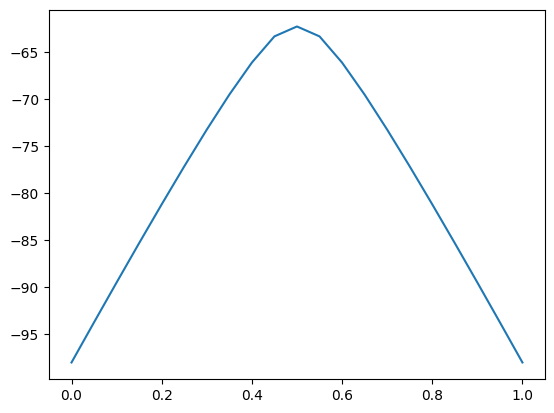

In [28]:
plt.plot(interpolation_values, energies_triv_proj_rep_list)

In [29]:
energies_non_triv_proj_rep_list = [energies_non_triv_proj_rep[k] for k in interpolation_values]

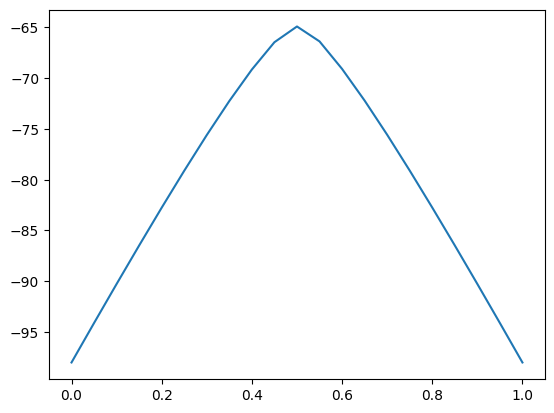

In [30]:
plt.plot(interpolation_values, energies_non_triv_proj_rep_list)

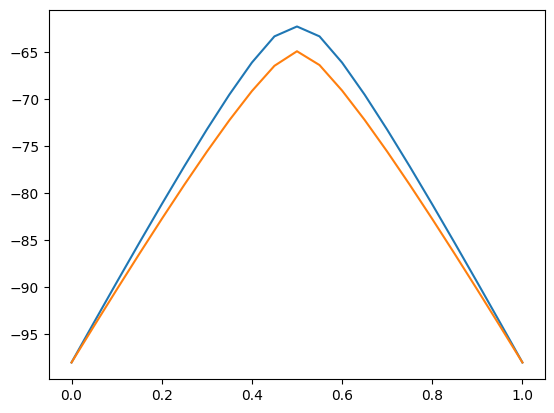

In [31]:
plt.plot(interpolation_values, energies_triv_proj_rep_list)
plt.plot(interpolation_values, energies_non_triv_proj_rep_list)

## Boson operator occupation

In [32]:
non_trivial_bosonic_npc_symmetries = bosonic_npc_symmetries[1:]

In [33]:
bosonic_operator_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_operator_triv_proj_rep_exps.append(list())
    psi = loaded_data_triv_proj_rep[t]
    for op in non_trivial_bosonic_npc_symmetries:
        out = psi.expectation_value(op, sites=[100,])[0]
        bosonic_operator_triv_proj_rep_exps[-1].append(out)

bosonic_operator_triv_proj_rep_exps = np.array(bosonic_operator_triv_proj_rep_exps)

In [34]:
bosonic_operator_triv_proj_rep_exps.shape

(21, 3)

In [35]:
non_trivial_bosonic_npc_symmetries_labels = ['IX', 'XI', 'XX']

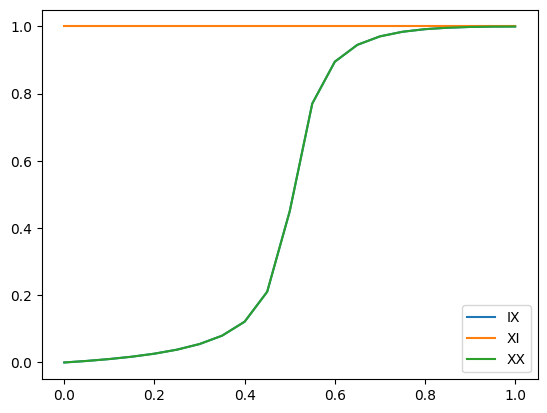

In [36]:
for i in range(len(non_trivial_bosonic_npc_symmetries)):
    plt.plot(
        interpolation_values,
        bosonic_operator_triv_proj_rep_exps[:, i],
    label = non_trivial_bosonic_npc_symmetries_labels[i]
    )

plt.legend()

In [37]:
bosonic_operator_non_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_operator_non_triv_proj_rep_exps.append(list())
    psi = loaded_data_non_triv_proj_rep[t]
    for op in non_trivial_bosonic_npc_symmetries:
        out = psi.expectation_value(op, sites=[100,])[0]
        bosonic_operator_non_triv_proj_rep_exps[-1].append(out)

bosonic_operator_non_triv_proj_rep_exps = np.array(bosonic_operator_non_triv_proj_rep_exps)

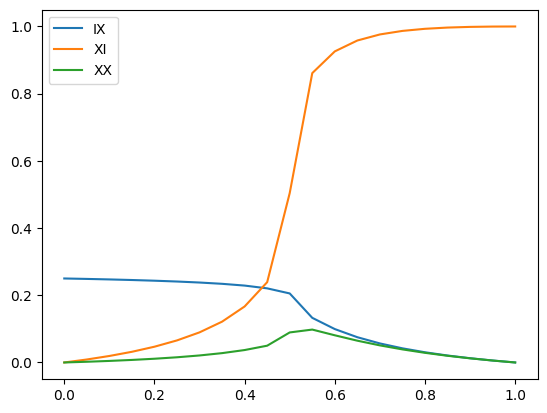

In [38]:
for i in range(len(non_trivial_bosonic_npc_symmetries)):
    plt.plot(
        interpolation_values,
        bosonic_operator_non_triv_proj_rep_exps[:, i],
    label = non_trivial_bosonic_npc_symmetries_labels[i]
    )

plt.legend()

Zeroes explained by "string order parameter" like argument? i.e. can investigate charges?

Possibly exactly SOPs if used longer bulk region?

## Fermion occupation

In [39]:
fermion_occupation_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    out = psi.expectation_value('N', sites=[99,])[0]
    fermion_occupation_triv_proj_rep.append(out)

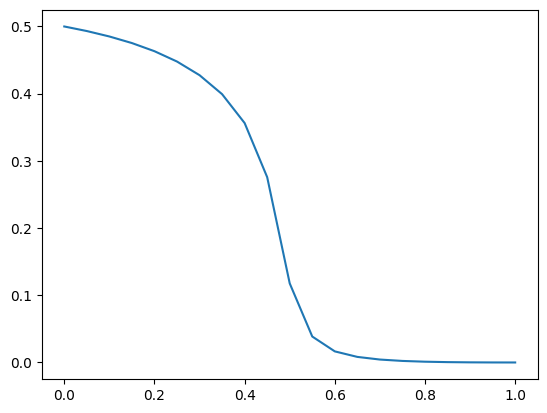

In [40]:
plt.plot(interpolation_values, fermion_occupation_triv_proj_rep)

In [41]:
fermion_occupation_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    out = psi.expectation_value('N', sites=[99,])[0]
    fermion_occupation_non_triv_proj_rep.append(out)

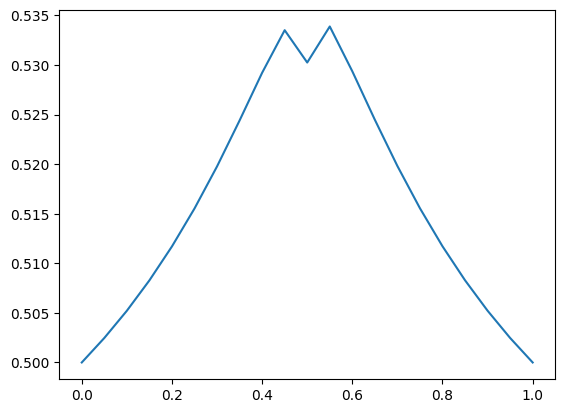

In [42]:
plt.plot(interpolation_values, fermion_occupation_non_triv_proj_rep)

## Correlation lengths

### Fermion occupation

In [43]:
def get_two_point_fn_expectation(psi, distance):
    ops = ['N',] + ['Id',]*(2*distance-1) + ['N']

    left_site = (200 - distance)//2

    if (left_site % 2) == 0:
        left_site += 1

    return psi.expectation_value_multi_sites(ops, left_site)

In [44]:
distances = list(range(1, 21))

In [45]:
fermion_occupation_2_point_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    out = [
        get_two_point_fn_expectation(psi, d)
        for d in distances
    ]
    fermion_occupation_2_point_triv_proj_rep.append(out)

fermion_occupation_2_point_triv_proj_rep = np.array(
    fermion_occupation_2_point_triv_proj_rep
)

In [46]:
fermion_occupation_2_point_triv_proj_rep.shape

(21, 20)

In [47]:
fermion_occupation_correlation_triv_proj_rep = (
    fermion_occupation_2_point_triv_proj_rep
    - (np.array(fermion_occupation_triv_proj_rep)**2)[:, np.newaxis]
)

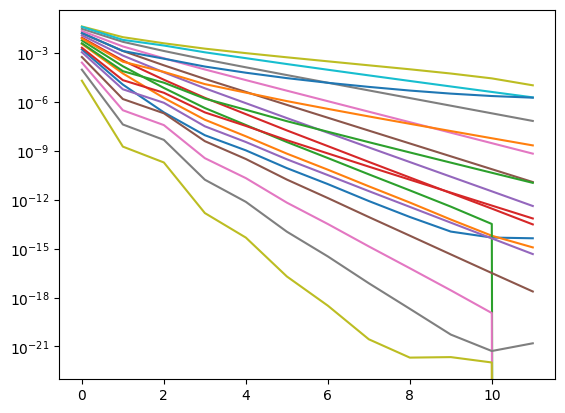

In [48]:
for X in fermion_occupation_correlation_triv_proj_rep[1:-1]:
    plt.plot(X[:12])

plt.yscale('log')

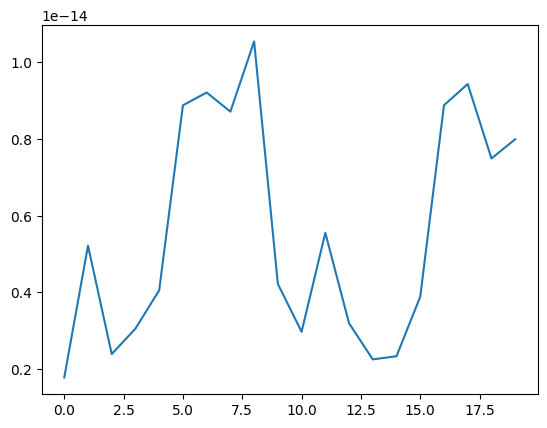

In [49]:
plt.plot(fermion_occupation_correlation_triv_proj_rep[0])

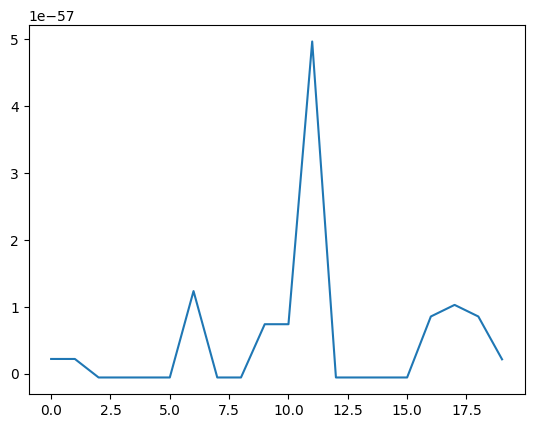

In [50]:
plt.plot(fermion_occupation_correlation_triv_proj_rep[-1])

In [51]:
X = fermion_occupation_correlation_triv_proj_rep

fermion_occupation_correlation_lengths_triv_proj_rep = 2/np.log(X[:,0]/X[:,2])
fermion_occupation_correlation_lengths_triv_proj_rep[0] = 0
fermion_occupation_correlation_lengths_triv_proj_rep[-1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_46367/478957739.py:3: RuntimeWarning: invalid value encountered in log
  fermion_occupation_correlation_lengths_triv_proj_rep = 2/np.log(X[:,0]/X[:,2])


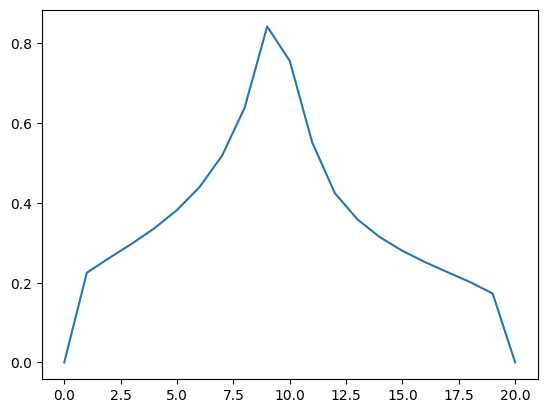

In [52]:
plt.plot(fermion_occupation_correlation_lengths_triv_proj_rep)

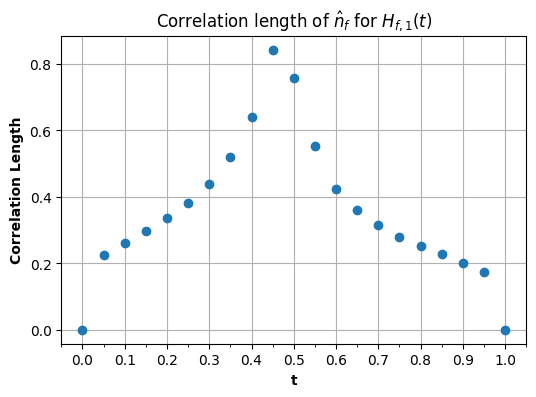

In [53]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    interpolation_values,
    fermion_occupation_correlation_lengths_triv_proj_rep,
    'o'
)

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#
ax.set_xlabel("t", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.set_title(r"Correlation length of $\hat{n}_f$ for $H_{f,1}(t)$")
fig.savefig(r'plots/trivial_fermion_phase_n_correlation_lengths.png', dpi=200)

In [54]:
fermion_occupation_2_point_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    out = [
        get_two_point_fn_expectation(psi, d)
        for d in distances
    ]
    fermion_occupation_2_point_non_triv_proj_rep.append(out)

fermion_occupation_2_point_non_triv_proj_rep = np.array(
    fermion_occupation_2_point_non_triv_proj_rep
)

In [55]:
fermion_occupation_correlation_non_triv_proj_rep = (
    fermion_occupation_2_point_non_triv_proj_rep
    - (np.array(fermion_occupation_non_triv_proj_rep)**2)[:, np.newaxis]
)

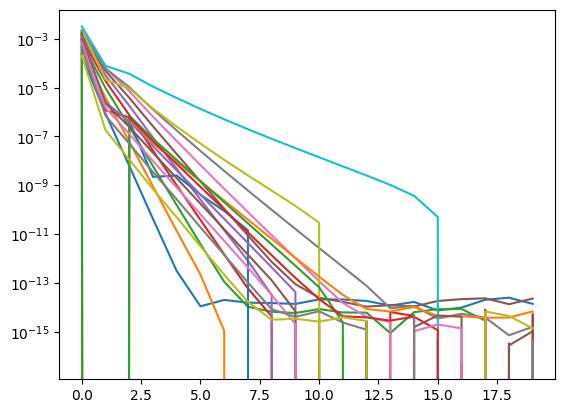

In [56]:
for X in fermion_occupation_correlation_non_triv_proj_rep[1:-1]:
    plt.plot(X)

plt.yscale('log')

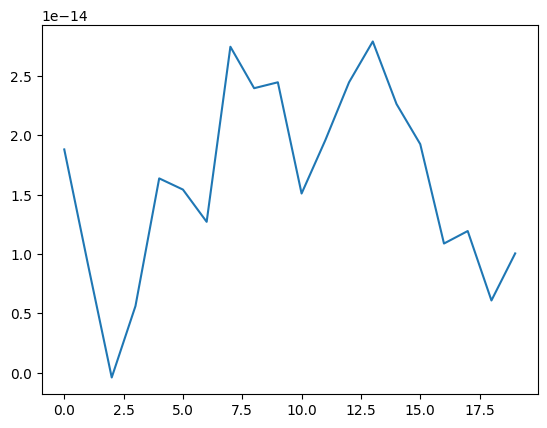

In [57]:
plt.plot(fermion_occupation_correlation_non_triv_proj_rep[0])

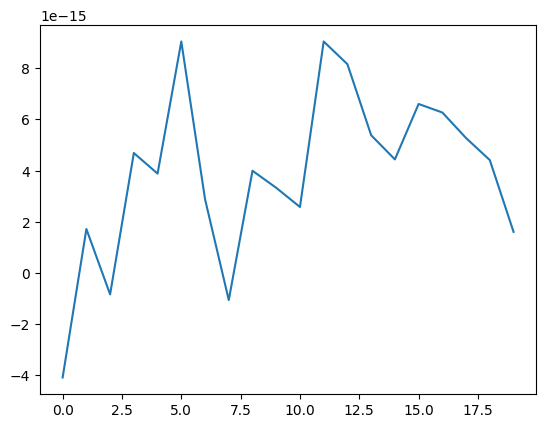

In [58]:
plt.plot(fermion_occupation_correlation_non_triv_proj_rep[-1])

In [59]:
X = fermion_occupation_correlation_non_triv_proj_rep

fermion_occupation_correlation_lengths_non_triv_proj_rep = 2/np.log(X[:,0]/X[:,2])
fermion_occupation_correlation_lengths_non_triv_proj_rep[0] = 0
fermion_occupation_correlation_lengths_non_triv_proj_rep[-1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_46367/2608423047.py:3: RuntimeWarning: invalid value encountered in log
  fermion_occupation_correlation_lengths_non_triv_proj_rep = 2/np.log(X[:,0]/X[:,2])


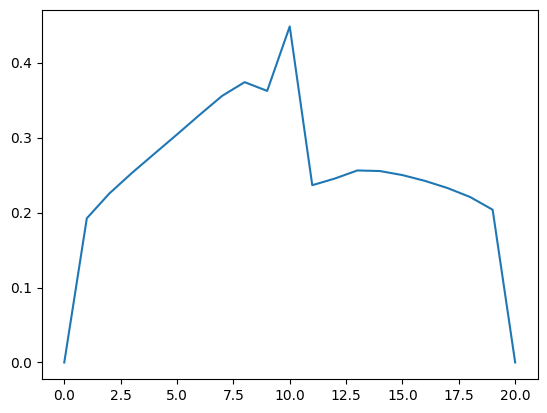

In [60]:
plt.plot(fermion_occupation_correlation_lengths_non_triv_proj_rep)

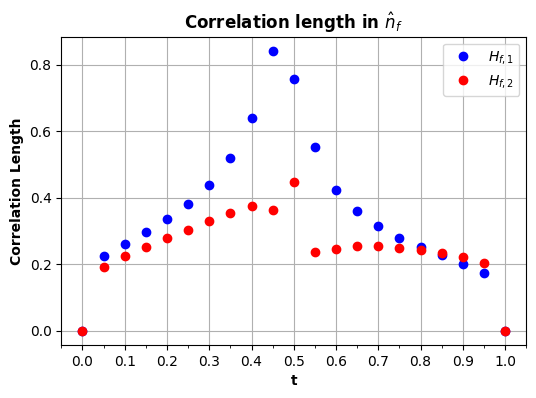

In [61]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    interpolation_values,
    fermion_occupation_correlation_lengths_triv_proj_rep,
    'bo',
    label = '$H_{f,1}$'
)

ax.plot(
    interpolation_values,
    fermion_occupation_correlation_lengths_non_triv_proj_rep,
    'ro',
    label = '$H_{f,2}$'
)

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#
ax.set_xlabel("t", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.legend(loc='upper right')

ax.set_title(r"Correlation length in $\hat{n}_f$", fontweight='bold')
fig.savefig(r'plots/n_correlation_lengths.png', dpi=200)

Centered at a different location than expected? Compare against cohomology caclulations.

Very short correlation legnths in general.

Non_trivial case looks weird...

### Boson operators occupation

In [62]:
def get_two_point_boson_op_expectation(psi, distance, op):
    ops = [op,] + ['Id',]*(2*distance-1) + [op]

    left_site = (200 - distance)//2

    if (left_site % 2) == 1:
        left_site += 1

    return psi.expectation_value_multi_sites(ops, left_site)

In [63]:
distances = list(range(1, 21))

In [64]:
non_trivial_bosonic_npc_symmetries

[<npc.Array shape=(4, 4) labels=['p', 'p*']>,
 <npc.Array shape=(4, 4) labels=['p', 'p*']>,
 <npc.Array shape=(4, 4) labels=['p', 'p*']>]

In [65]:
boosn_occupation_2_point_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    boosn_occupation_2_point_triv_proj_rep.append(list())
    for op in non_trivial_bosonic_npc_symmetries:
        out = [
            get_two_point_boson_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_occupation_2_point_triv_proj_rep[-1].append(out)

boosn_occupation_2_point_triv_proj_rep = np.array(
    boosn_occupation_2_point_triv_proj_rep
)

In [66]:
boosn_occupation_2_point_triv_proj_rep.shape

(21, 3, 20)

In [67]:
boson_occupation_correlation_triv_proj_rep = (
    boosn_occupation_2_point_triv_proj_rep
    - (np.array(bosonic_operator_triv_proj_rep_exps)**2)[..., np.newaxis]
)

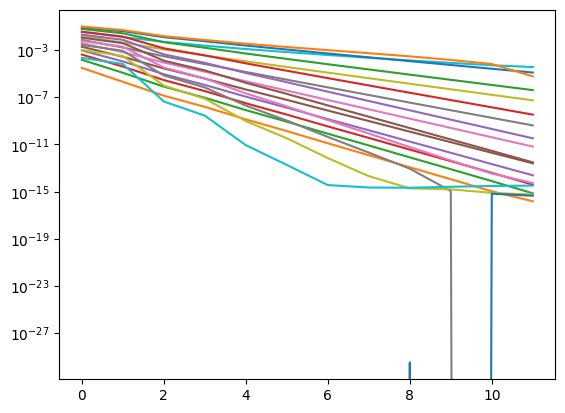

In [68]:
for X in boson_occupation_correlation_triv_proj_rep[:, 0, :]:
    plt.plot(X[:12])

plt.yscale('log')

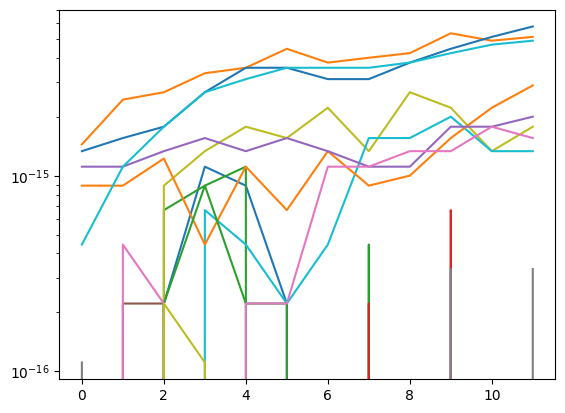

In [69]:
for X in boson_occupation_correlation_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

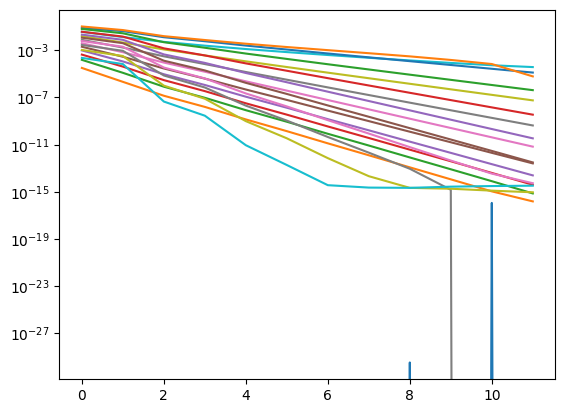

In [70]:
for X in boson_occupation_correlation_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [71]:
np.max(boson_occupation_correlation_triv_proj_rep[[0, -1]])

1.3322676295501878e-15

In [72]:
np.max(boson_occupation_correlation_triv_proj_rep[:, 1])

7.771561172376096e-15

In [73]:
X = boson_occupation_correlation_triv_proj_rep[:, [0, 2], :]

boson_op_correlation_lengths_triv_proj_rep = 6/np.log(X[...,0]/X[...,6])
boson_op_correlation_lengths_triv_proj_rep[0] = 0
boson_op_correlation_lengths_triv_proj_rep[-1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_46367/3207143794.py:3: RuntimeWarning: divide by zero encountered in log
  boson_op_correlation_lengths_triv_proj_rep = 6/np.log(X[...,0]/X[...,6])


In [74]:
boson_op_correlation_lengths_triv_proj_rep.shape

(21, 2)

Exactly the same... suspect.

In [75]:
X = boson_op_correlation_lengths_triv_proj_rep

np.max(np.abs(X[:, 0] - X[:, 1]))

6.425907650597917e-06

Text(0, 0.5, 'Correlation Length')

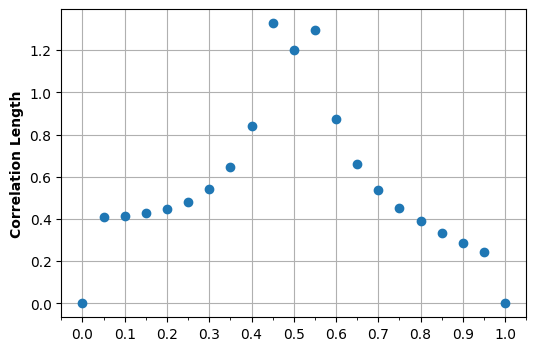

In [76]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    interpolation_values,
    boson_op_correlation_lengths_triv_proj_rep[:, 0],
    'o'
)

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#
ax.set_xlabel("", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

#ax.set_title("Correlation length in the ZXZ model as a function of B", fontweight='bold')

The correlation is very small, which makes some of these plots misleading.

In [77]:
boosn_occupation_2_point_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    boosn_occupation_2_point_non_triv_proj_rep.append(list())
    for op in non_trivial_bosonic_npc_symmetries:
        out = [
            get_two_point_boson_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_occupation_2_point_non_triv_proj_rep[-1].append(out)

boosn_occupation_2_point_non_triv_proj_rep = np.array(
    boosn_occupation_2_point_non_triv_proj_rep
)

In [78]:
boson_occupation_correlation_non_triv_proj_rep = (
    boosn_occupation_2_point_non_triv_proj_rep
    - (np.array(bosonic_operator_non_triv_proj_rep_exps)**2)[..., np.newaxis]
)

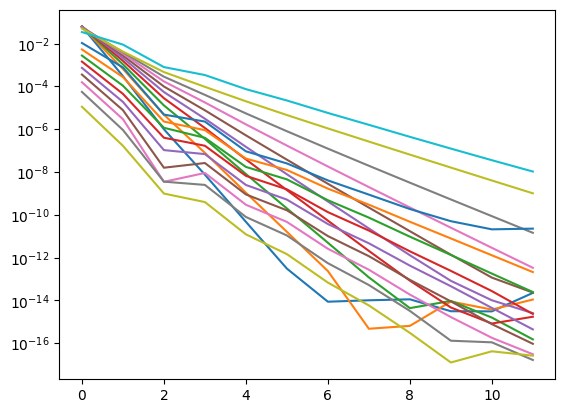

In [79]:
for X in boson_occupation_correlation_non_triv_proj_rep[1:-1, 0, :]:
    plt.plot(np.abs(X[:12]))

plt.yscale('log')

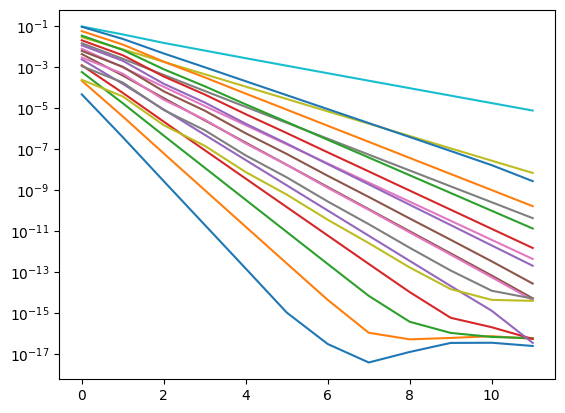

In [80]:
for X in boson_occupation_correlation_non_triv_proj_rep[1:-1, 1, :]:
    plt.plot(np.abs(X[:12]))

plt.yscale('log')

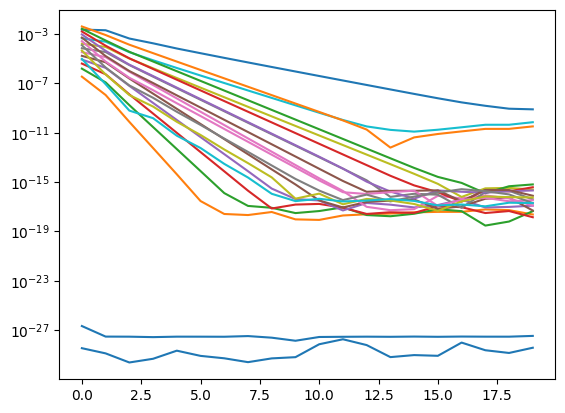

In [81]:
for X in boson_occupation_correlation_non_triv_proj_rep[:, 2, :]:
    plt.plot(np.abs(X))

plt.yscale('log')

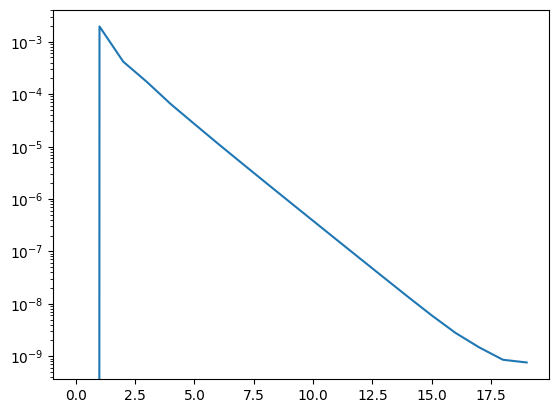

In [82]:
plt.plot(boson_occupation_correlation_non_triv_proj_rep[10, 2, :])

plt.yscale('log')

Crazy behaviour at critical point.

In [83]:
np.max(boson_occupation_correlation_non_triv_proj_rep[[0, -1]])

1.071365218763276e-14

In [84]:
X = boson_occupation_correlation_non_triv_proj_rep

boson_op_correlation_lengths_non_triv_proj_rep = 5/np.log(np.abs(X[...,0]/X[...,5]))
boson_op_correlation_lengths_non_triv_proj_rep[0] = 0
boson_op_correlation_lengths_non_triv_proj_rep[-1] = 0

In [85]:
boson_op_correlation_lengths_non_triv_proj_rep.shape

(21, 3)

In [86]:
markers = ['>', '<', '^']

In [87]:
boson_op_correlation_lengths_triv_proj_rep.shape

(21, 2)

In [88]:
boson_op_correlation_lengths_non_triv_proj_rep.shape

(21, 3)

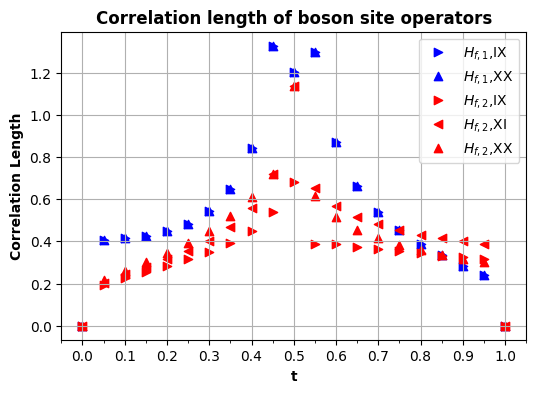

In [89]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    interpolation_values,
    boson_op_correlation_lengths_triv_proj_rep[:, 0],
    marker=markers[0],
    color='blue',
    label=r'$H_{f,1}$,' + non_trivial_bosonic_npc_symmetries_labels[0]
)


ax.scatter(
    interpolation_values,
    boson_op_correlation_lengths_triv_proj_rep[:, 1],
    marker=markers[2],
    color='blue',
    label=r'$H_{f,1}$,' + non_trivial_bosonic_npc_symmetries_labels[2]
)

for i, l in enumerate(non_trivial_bosonic_npc_symmetries_labels):
    marker = markers[i]
    ax.scatter(
        interpolation_values,
        boson_op_correlation_lengths_non_triv_proj_rep[:, i],
        marker=marker,
        color='red',
        label=r'$H_{f,2}$,' + l
    )

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#
ax.set_xlabel("t", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.legend()

ax.set_title("Correlation length of boson site operators", fontweight='bold')

fig.savefig(r'plots/bosonic_operator_correlation_lengths.png', dpi=200)

### More general operators
Getting weird results, so look at correlations of operators like $XI \hat{n}$.

Expectations:

In [90]:
non_trivial_bosonic_npc_symmetries

[<npc.Array shape=(4, 4) labels=['p', 'p*']>,
 <npc.Array shape=(4, 4) labels=['p', 'p*']>,
 <npc.Array shape=(4, 4) labels=['p', 'p*']>]

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [92]:
bosonic_operator_n_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_operator_n_triv_proj_rep_exps.append(list())
    psi = loaded_data_triv_proj_rep[t]
    for op in non_trivial_bosonic_npc_symmetries:
        out = psi.expectation_value_multi_sites([op, 'N'], i0=100)
        bosonic_operator_n_triv_proj_rep_exps[-1].append(out)

bosonic_operator_n_triv_proj_rep_exps = np.array(bosonic_operator_n_triv_proj_rep_exps)

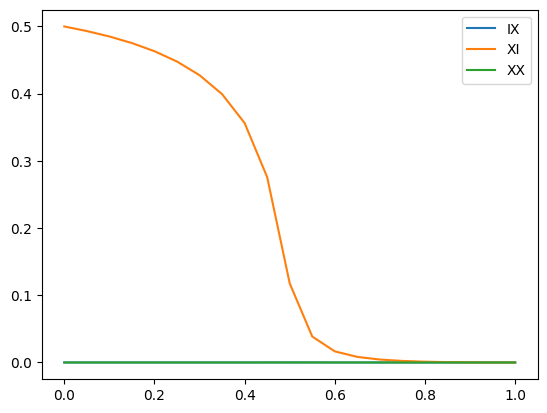

In [95]:
for i in range(len(non_trivial_bosonic_npc_symmetries)):
    plt.plot(
        interpolation_values,
        bosonic_operator_n_triv_proj_rep_exps[:, i],
    label = non_trivial_bosonic_npc_symmetries_labels[i]
    )

plt.legend()

In [93]:
bosonic_operator_n_non_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_operator_n_non_triv_proj_rep_exps.append(list())
    psi = loaded_data_non_triv_proj_rep[t]
    for op in non_trivial_bosonic_npc_symmetries:
        out = psi.expectation_value_multi_sites([op, 'N'], i0=100)
        bosonic_operator_n_non_triv_proj_rep_exps[-1].append(out)

bosonic_operator_n_non_triv_proj_rep_exps = np.array(bosonic_operator_n_non_triv_proj_rep_exps)

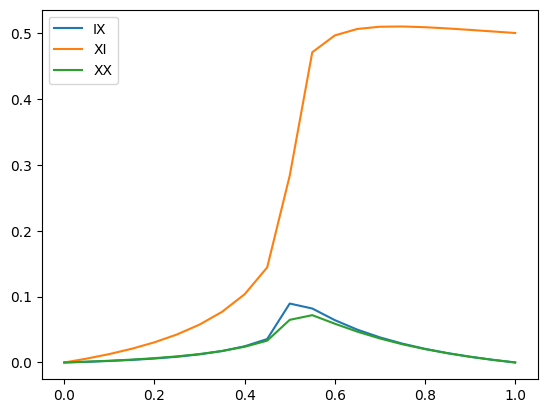

In [96]:
for i in range(len(non_trivial_bosonic_npc_symmetries)):
    plt.plot(
        interpolation_values,
        bosonic_operator_n_non_triv_proj_rep_exps[:, i],
    label = non_trivial_bosonic_npc_symmetries_labels[i]
    )

plt.legend()

In [107]:
def get_two_point_boson_fn_op_expectation(psi, distance, op):
    ops = [op, 'N'] + ['Id',]*(2*distance) + [op, 'N']

    left_site = 100 - 2 - 2*distance

    return psi.expectation_value_multi_sites(ops, left_site)

In [108]:
loaded_data_triv_proj_rep[0].get_B(0)

<npc.Array shape=(1, 4, 1) labels=['vL', 'p', 'vR']>

In [109]:
boosn_occupation_n_2_point_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    boosn_occupation_n_2_point_triv_proj_rep.append(list())
    for op in non_trivial_bosonic_npc_symmetries:
        out = [
            get_two_point_boson_fn_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_occupation_n_2_point_triv_proj_rep[-1].append(out)

boosn_occupation_n_2_point_triv_proj_rep = np.array(
    boosn_occupation_n_2_point_triv_proj_rep
)

In [110]:
boson_occupation_n_correlation_triv_proj_rep = (
    boosn_occupation_n_2_point_triv_proj_rep
    - (np.array(bosonic_operator_n_triv_proj_rep_exps)**2)[..., np.newaxis]
)

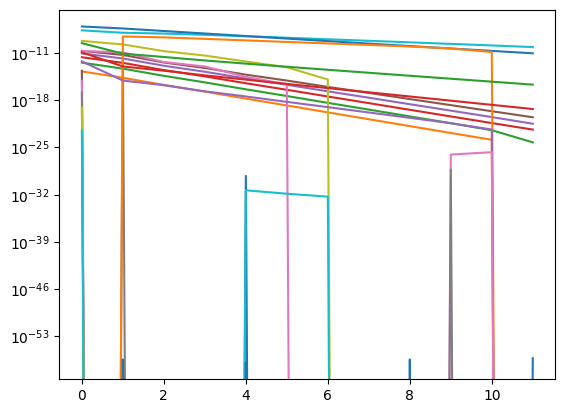

In [111]:
for X in boson_occupation_n_correlation_triv_proj_rep[:, 0, :]:
    plt.plot(X[:12])

plt.yscale('log')

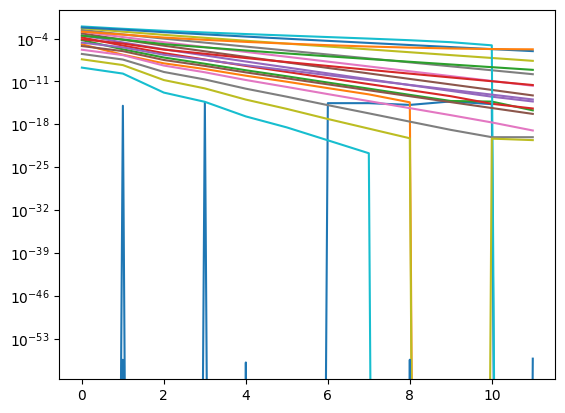

In [112]:
for X in boson_occupation_n_correlation_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

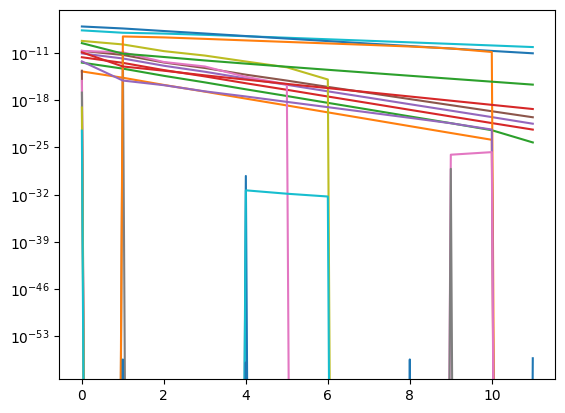

In [113]:
for X in boson_occupation_n_correlation_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [114]:
boosn_occupation_n_2_point_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    boosn_occupation_n_2_point_non_triv_proj_rep.append(list())
    for op in non_trivial_bosonic_npc_symmetries:
        out = [
            get_two_point_boson_fn_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_occupation_n_2_point_non_triv_proj_rep[-1].append(out)

boosn_occupation_n_2_point_non_triv_proj_rep = np.array(
    boosn_occupation_n_2_point_non_triv_proj_rep
)

In [115]:
boson_occupation_n_correlation_non_triv_proj_rep = (
    boosn_occupation_n_2_point_non_triv_proj_rep
    - (np.array(bosonic_operator_n_non_triv_proj_rep_exps)**2)[..., np.newaxis]
)

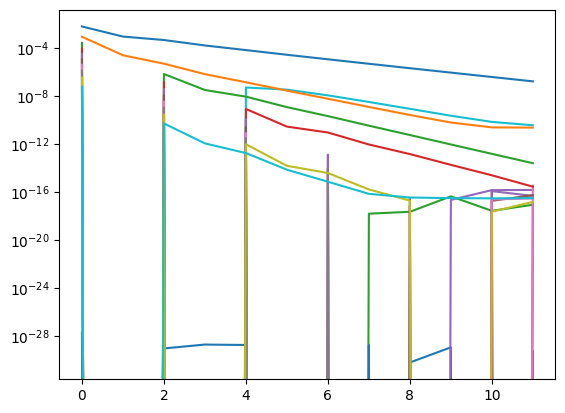

In [116]:
for X in boson_occupation_n_correlation_non_triv_proj_rep[:, 0, :]:
    plt.plot(X[:12])

plt.yscale('log')

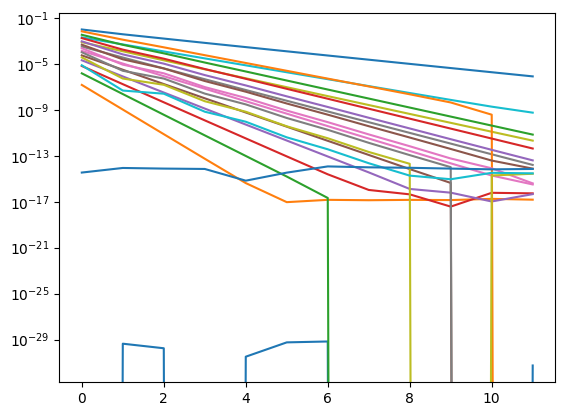

In [117]:
for X in boson_occupation_n_correlation_non_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

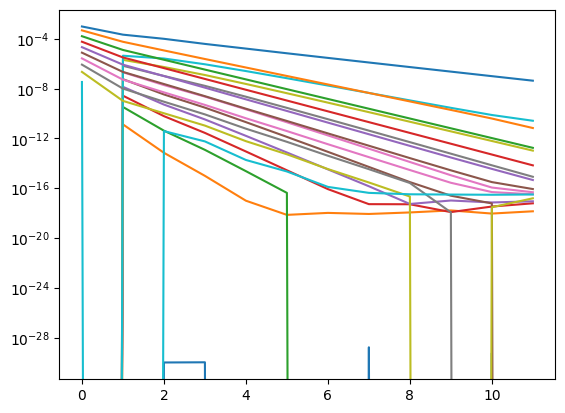

In [118]:
for X in boson_occupation_n_correlation_non_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [119]:
non_trivial_bosonic_npc_symmetries_labels

['IX', 'XI', 'XX']

### Final plot

In [122]:
boson_op_correlation_lengths_triv_proj_rep[:, 0]

array([0.        , 0.40747345, 0.4155897 , 0.42757511, 0.44707303,
       0.48130195, 0.54154916, 0.64586556, 0.84137717, 1.32741006,
       1.2006655 , 1.29782923, 0.87124523, 0.66214118, 0.53848862,
       0.45329091, 0.38813153, 0.33377737, 0.28403423, 0.24138604,
       0.        ])

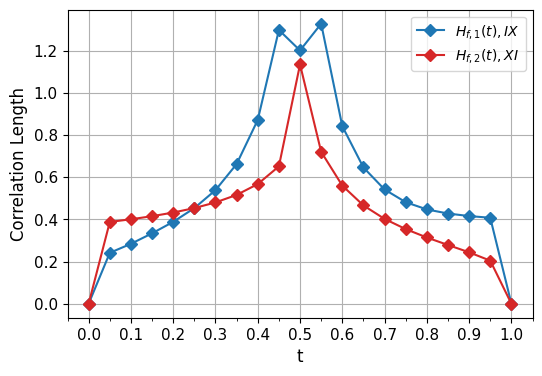

In [129]:
fig, ax = plt.subplots(figsize=(6, 4))

# Reverse interpolation values due to annoying ordering error I made.
ax.plot(
    interpolation_values[::-1],
    boson_op_correlation_lengths_triv_proj_rep[:, 0],
    color='tab:blue',
    marker='D',
    label=r'$H_{f,1}(t), IX$',
)

ax.plot(
    interpolation_values[::-1],
    boson_op_correlation_lengths_non_triv_proj_rep[:, 1],
    color='tab:red',
    marker='D',
    label=r'$H_{f,2}(t), XI$'
)

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(
    axis='both',
    which='major',
    labelsize=11
)

ax.set_xlabel("t", fontsize=12)
ax.set_ylabel("Correlation Length", fontsize=12)

ax.legend()

fig.savefig(r'plots/fermionic_state_correlation_lengths.png', dpi=200)

# Conclusions

Correlations typically weak, especially in the trivial proj rep states. Makes it difficult to extract correlation length robustly.